In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

## The data -- grocery checkout times

In [2]:
checkout_times = Table.read_table("groceries.csv")

In [3]:
checkout_times.show(3)

Items,Time
39,236
38,179
41,150


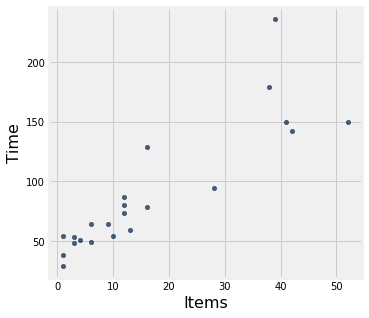

In [4]:
checkout_times.scatter('Items', 'Time')

## Making predictions with this data

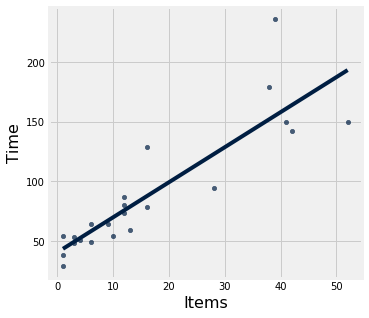

In [5]:
checkout_times.scatter('Items', 'Time', fit_line=True)

In [6]:
ct_guess_slope = 3
ct_guess_intercept = 40

## Prediction

In [7]:
ct_guess_slope * 3 + ct_guess_intercept

49

In [8]:
ct_guess_slope * 5 + ct_guess_intercept

55

In [9]:
ct_guess_slope * 2 + ct_guess_intercept

46

In [10]:
ct_guess_slope * 1 + ct_guess_intercept

43

In [11]:
ct_guess_slope * 19 + ct_guess_intercept

97

In [12]:
def fit(table, x, y, a, b):
    """Return the height of the regression line at each x value."""
    return a * table.column(x) + b

In [13]:
ct_fitted = checkout_times.with_column('Fitted', fit(checkout_times, 'Items', 'Time', ct_guess_slope, ct_guess_intercept))

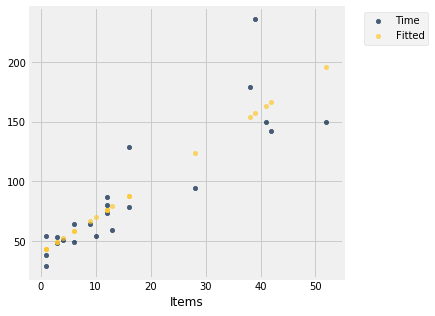

In [14]:
ct_fitted.scatter('Items')

## Errors in prediction

In [15]:
checkout_times.show(3)

Items,Time
39,236
38,179
41,150


In [16]:
selected_pts = [[10, 54], [16,78], [28, 94], [38, 179]]
def ct_errors(slope, intercept):
    print('Slope:    ', np.round(slope, decimals=1), 'seconds per item')
    print('Intercept:', np.round(intercept, decimals=1), 'seconds')
    checkout_times.scatter('Items', 'Time')
    xlims = np.array([0, 60])
    plots.plot(xlims, slope * xlims + intercept, lw=2)
    for x, y in selected_pts:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=2)

Slope:     3 seconds per item
Intercept: 40 seconds


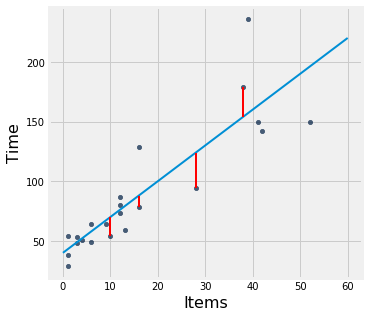

In [17]:
ct_errors(ct_guess_slope, ct_guess_intercept)

## Best fit line

Slope:     1 seconds per item
Intercept: 70 seconds


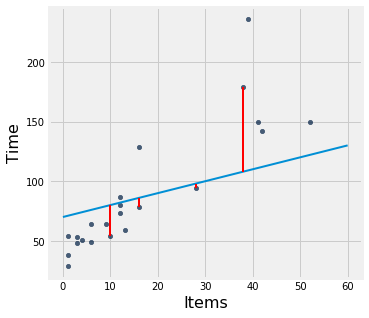

In [18]:
ct_errors(1, 70)

Slope:     -2 seconds per item
Intercept: 180 seconds


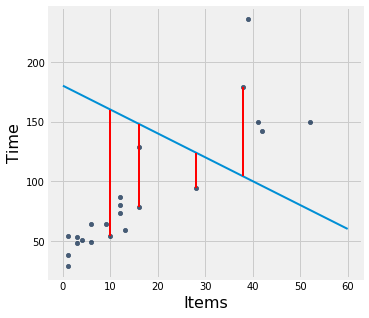

In [19]:
ct_errors(-2, 180)

In [20]:
def plot_rmse(slope, intercept):
    ct_errors(slope, intercept)
    x = checkout_times.column('Items')
    y = checkout_times.column('Time')
    fitted = slope * x + intercept
    mse = np.mean((y - fitted) ** 2)
    print("Root mean squared error:", mse ** 0.5)

Slope:     1 seconds per item
Intercept: 70 seconds
Root mean squared error: 38.9988344814


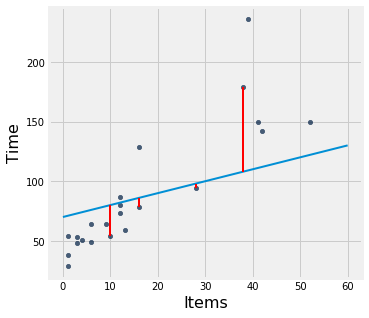

In [21]:
plot_rmse(1, 70)

Slope:     -2 seconds per item
Intercept: 180 seconds
Root mean squared error: 98.7745366525


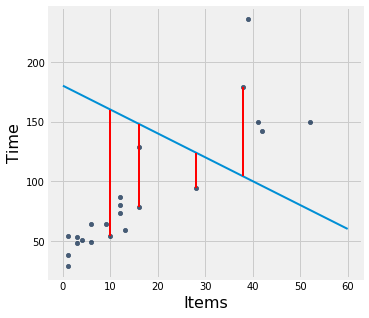

In [22]:
plot_rmse(-2, 180)

Slope:     2.5 seconds per item
Intercept: 40 seconds
Root mean squared error: 26.9268791022


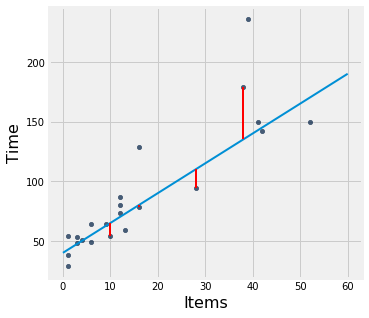

In [23]:
plot_rmse(2.5, 40)

Slope:     3 seconds per item
Intercept: 40 seconds
Root mean squared error: 24.9508607977


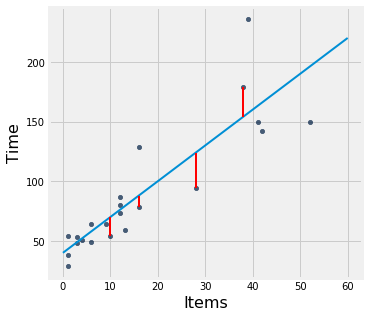

In [24]:
plot_rmse(ct_guess_slope, ct_guess_intercept)

## Numerical optimization

In [25]:
def f(x):
    return (x - 3)*(x - 3) + 1

In [26]:
[f(1), f(2), f(3), f(4), f(5)]

[5, 2, 1, 2, 5]

In [27]:
minimize(f)

2.999999999968361

In [28]:
f(minimize(f))

1.0

In [29]:
def rmse(any_slope, any_intercept):
    x = checkout_times.column('Items')
    y = checkout_times.column('Time')
    fitted = any_slope*x + any_intercept
    return np.mean((y - fitted) ** 2) ** 0.5

Slope:     3 seconds per item
Intercept: 40 seconds
Root mean squared error: 24.9508607977


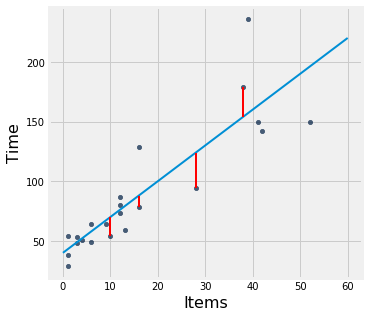

In [30]:
plot_rmse(3, 40)

In [31]:
rmse(3, 40)

24.950860797685007

In [32]:
best = minimize(rmse)

In [33]:
best

array([  2.9356136 ,  40.43190467])

## Using the formulas

In [34]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)  

def correlation(t, x, y):
    """Return the correlation coefficient (r) of two variables."""
    return np.mean(standard_units(t.column(x)) * standard_units(t.column(y)))

def slope(t, x, y):
    """The slope of the regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

In [35]:
ct_fit_slope = slope(checkout_times, 'Items', 'Time')
ct_fit_slope

2.9356135774760168

In [36]:
ct_fit_intercept = intercept(checkout_times, 'Items', 'Time')
ct_fit_intercept

40.43186564642064

In [37]:
best

array([  2.9356136 ,  40.43190467])

In [38]:
make_array(ct_fit_slope, ct_fit_intercept)

array([  2.93561358,  40.43186565])

## Confidence intervals for a prediction

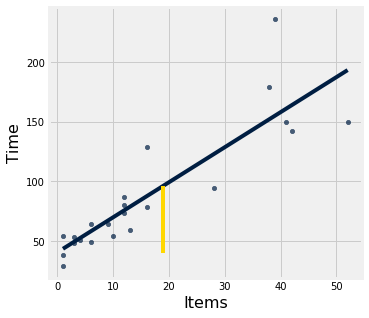

In [39]:
x = 19
observed_y = 40
a = slope(checkout_times, 'Items', 'Time')
b = intercept(checkout_times, 'Items', 'Time')
predicted_y = a * x + b
checkout_times.scatter('Items', 'Time', fit_line=True)
plots.plot([x, x], [observed_y, predicted_y], color='gold');

In [40]:
predicted_y

96.208523618464966

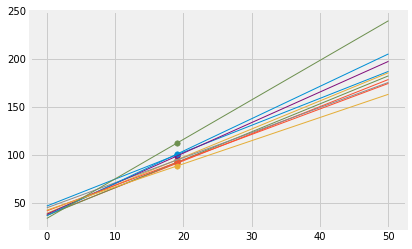

In [41]:
lines = Table(['slope','intercept', 'at 0', 'at 19', 'at 50'])

for i in range(10):
    resample = checkout_times.sample()
    a = slope(resample, 'Items', 'Time')
    b = intercept(resample, 'Items', 'Time')
    lines.append([a, b, a * 0 + b, a * 19 + b, a * 50 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([0, 50], [line.item('at 0'), line.item('at 50')], lw=1)
    plots.scatter(19, line.item('at 19'), s=30)

In [42]:
def bootstrap_prediction(table, x, y, new_x, repetitions=5000):

    # Bootstrap resampling
    predictions = []
    for i in np.arange(repetitions):
        resample = table.sample()
        a = slope(resample, x, y)
        b = intercept(resample, x, y)
        fitted_y = a * new_x + b
        predictions.append(fitted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval of predicted time:')
    print(left, right, '(width =', right - left, ')')

Approximate 95%-confidence interval of predicted time:
84.8565497253 111.050269251 (width = 26.1937195254 )


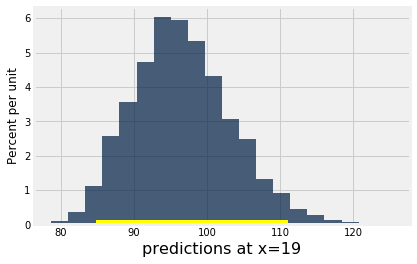

In [43]:
bootstrap_prediction(checkout_times, 'Items', 'Time', 19)

Approximate 95%-confidence interval of predicted time:
153.909205087 240.848280633 (width = 86.9390755461 )


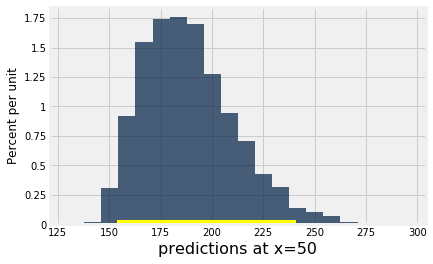

In [44]:
bootstrap_prediction(checkout_times, 'Items', 'Time', 50)

Approximate 95%-confidence interval of predicted time:
28.0859138973 49.935607699 (width = 21.8496938017 )


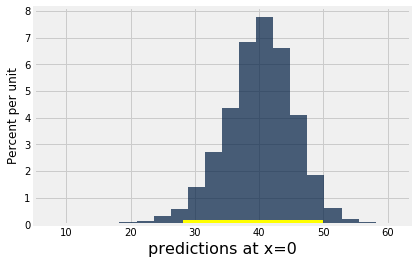

In [45]:
bootstrap_prediction(checkout_times, 'Items', 'Time', 0)

## Regression model

In [46]:
def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter(0, 1)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    sample.scatter(0, 1)
    plots.title('What We Get to See')

    sample.scatter(0, 1, fit_line=True)
    plots.title('Regression Line: Estimate of True Line')

    sample.scatter(0, 1, fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")

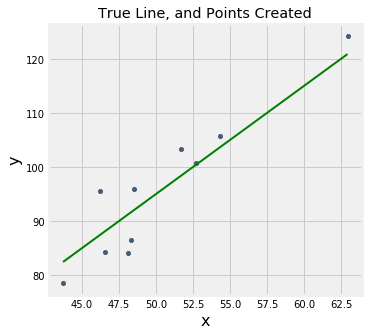

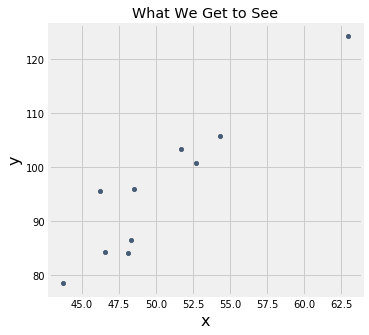

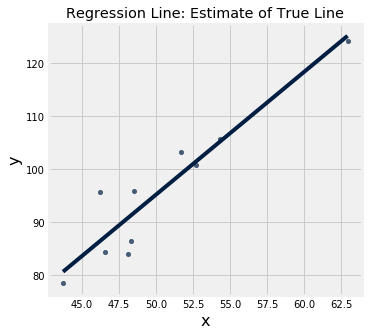

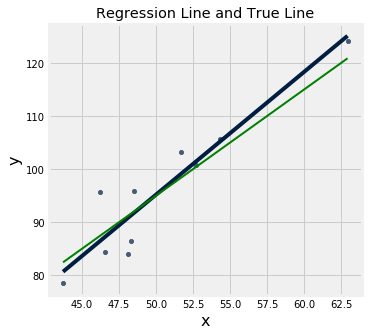

In [47]:
draw_and_compare(2, -5, 10)

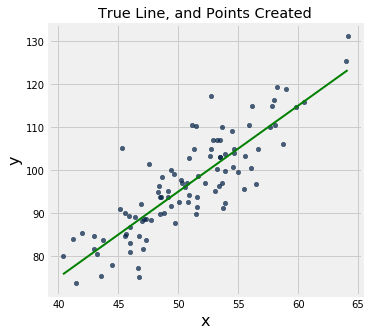

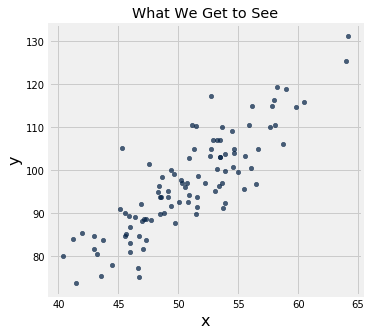

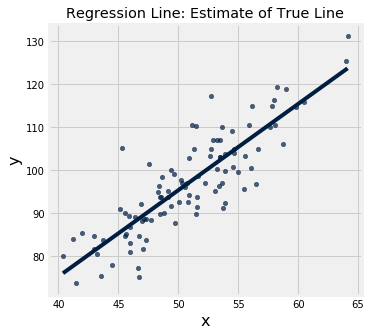

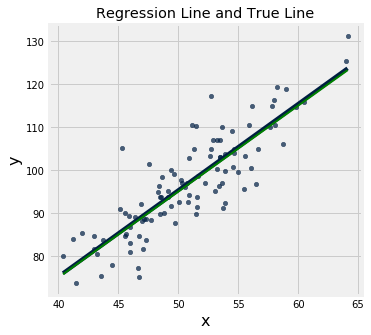

In [48]:
draw_and_compare(2, -5, 100)

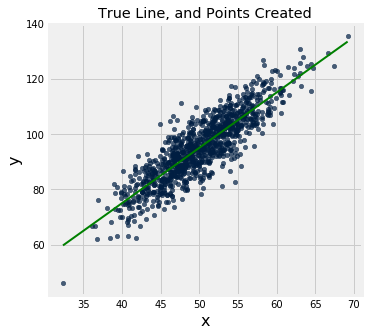

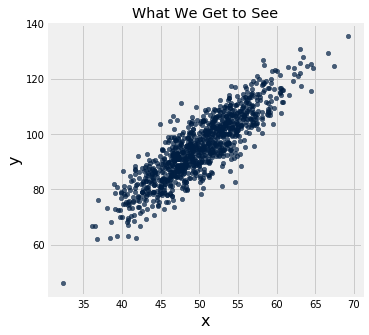

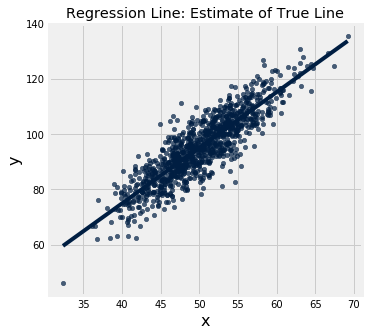

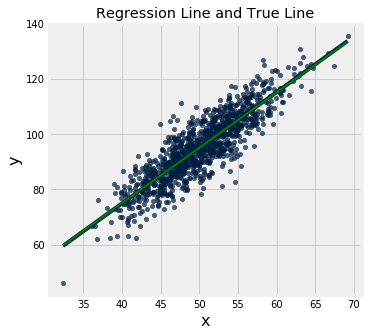

In [49]:
draw_and_compare(2, -5, 1000)